In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import anndata
from anndata import read_h5ad
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import random
import torch.nn as nn
from torch.optim import Adam
from entmax import entmax15, entmax_bisect
from sparsemax import Sparsemax
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

In [2]:
class simdatset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        x = torch.from_numpy(self.X[index]).float().to(device)
        y = torch.from_numpy(self.Y[index]).float().to(device)
        return x, y


    
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.name = 'ae'
        self.state = 'train' # or 'test'
        self.inputdim = input_dim
        self.outputdim = output_dim
        self.encoder = nn.Sequential(nn.Dropout(),
                                     nn.Linear(self.inputdim, 512),
                                     nn.CELU(),
                                     nn.Dropout(),
                                     nn.Linear(512, 256),
                                     nn.CELU(),
                                     nn.Dropout(),
                                     nn.Linear(256, 128),
                                     nn.CELU(),
                                     nn.Dropout(),
                                     nn.Linear(128, 64),
                                     nn.CELU(),
                                     nn.Linear(64, output_dim),
                                     )

        self.decoder = nn.Sequential(nn.Linear(self.outputdim, 64, bias=False),
                                     nn.Linear(64, 128, bias=False),
                                     nn.Linear(128, 256, bias=False),
                                     nn.Linear(256, 512, bias=False),
                                     nn.Linear(512, self.inputdim, bias=False))

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def refraction(self,x):
        x_sum = torch.sum(x, dim=1, keepdim=True)
        return x/x_sum

    
    def sigmatrix(self):
        w0 = self.decoder[0].weight.T
        w1 = self.decoder[1].weight.T
        w2 = self.decoder[2].weight.T
        w3 = self.decoder[3].weight.T
        w4 = self.decoder[4].weight.T
        w01 = (torch.mm(w0, w1))
        w02 = (torch.mm(w01, w2))
        w03 = (torch.mm(w02, w3))
        w04 = F.hardtanh(torch.mm(w03, w4),0,1)
        return w04

    def forward(self, x):
        sigmatrix = self.sigmatrix()
        z = self.encode(x)
        #z = self.own_softmax(z)
        if self.state == 'train':
            z = F.hardtanh(z,0,1)

        elif self.state == 'test':
            
            z = F.hardtanh(z,0,1)
            z = self.refraction(z)
        x_recon = torch.mm(z, sigmatrix)
        return x_recon, z, sigmatrix


def L1error(pred, true):
    return np.mean(np.abs(pred - true))


def CCCscore(y_pred, y_true):
    # pred: shape{n sample, m cell}
    ccc_value = 0
    for i in range(y_pred.shape[1]):
        r = np.corrcoef(y_pred[:, i], y_true[:, i])[0, 1]
        # print(r)
        # Mean
        mean_true = np.mean(y_true[:, i])
        mean_pred = np.mean(y_pred[:, i])
        # Variance
        var_true = np.var(y_true[:, i])
        var_pred = np.var(y_pred[:, i])
        # Standard deviation
        sd_true = np.std(y_true[:, i])
        sd_pred = np.std(y_pred[:, i])
        # Calculate CCC
        numerator = 2 * r * sd_true * sd_pred
        denominator = var_true + var_pred + (mean_true - mean_pred) ** 2
        ccc = numerator / denominator
        # print(ccc)
        ccc_value += ccc
    return ccc_value / y_pred.shape[1]

def score(pred, label):
    new_pred = pred.reshape(pred.shape[0]*pred.shape[1],1)
    new_label = label.reshape(label.shape[0]*label.shape[1],1)
    distance = L1error(new_pred, new_label)
    ccc = CCCscore(new_pred, new_label)
    return distance, ccc
    
def showloss(loss):
    plt.figure()
    plt.plot(loss)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.show()           
            
def plot_scatter(model,test_loader):
    for data, label in test_loader:
        ori = label
        pred, x_recon, l1 = model(data)
        break
    ori = ori.cpu().detach().numpy()
    pred = pred.cpu().detach().numpy()
    fig, ax = plt.subplots(pred.shape[1],sharex='col',sharey='row',figsize=(3,15),dpi=100)
    fig.suptitle('Results')
    cccValue = 0
    for i in range(pred.shape[1]):
        y = pred[:,i]
        x = ori[:,i]
        ax[i].scatter(x, y, s=10)
        z1 = np.polyfit(x, y, 1)
        p1 = np.poly1d(z1)
        x = x.reshape(-1,1)
        y = y.reshape(-1,1)
        ccc = CCCscore(x,y)
        cccValue += ccc
        ax[i].text(0.1,0.8,str(ccc))
        yvals=p1(x)
        ax[i].set_xlim(0,1)
        ax[i].set_ylim(0,1)
        ax[i].plot(x, yvals, 'r',label='polyfit values')
    print(cccValue/pred.shape[1])
    plt.show()          
            
def reproducibility(seed=1):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True


def training_stage(model, train_loader, optimizer, epochs=10):
    model.train()
    model.state = 'train'
    loss = []
    recon_loss = []
    for i in tqdm(range(epochs)):
        for k, (data, label) in enumerate(train_loader):
            optimizer.zero_grad()
            x_recon, cell_prop, sigm = model(data)
            batch_loss = F.l1_loss(cell_prop, label) + F.l1_loss(x_recon, data)
            batch_loss.backward()
            optimizer.step()
            loss.append(F.l1_loss(cell_prop, label).cpu().detach().numpy())
            recon_loss.append(F.l1_loss(x_recon, data).cpu().detach().numpy())

    return model, loss, recon_loss

def train_model(train_x, train_y,
                batch_size=128, iteration=5000, seed=0):
    reproducibility(seed)
    train_loader = DataLoader(simdatset(train_x, train_y), batch_size=batch_size, shuffle=True)
    model = AutoEncoder(train_x.shape[1], train_y.shape[1]).to(device)
    optimizer = Adam(model.parameters(), lr=1e-4)
    model, loss, reconloss = training_stage(model, train_loader, optimizer, epochs=int(iteration /(len(train_x)/128)))
    print('prediction loss is:')
    showloss(loss)
    print('reconstruction loss is:')
    showloss(reconloss)
    return model

        
def test(train_x, train_y, test_x, test_y, seed=0):
    reproducibility(seed)
    model = train_model(train_x, train_y, seed=seed)
    model.eval()
    model.state = 'test'
    data = torch.from_numpy(test_x).float().to(device)
    _, pred, _ = model(data)
    pred = pred.cpu().detach().numpy()
    a,b = score(pred,test_y)
    print(a,b)
    return a, b

In [3]:
def preprocess(trainingdatapath, testx=None, testy=None, testlabel='seq'):
    if (testx is not None) and (testy is not None):
        pbmc = read_h5ad(trainingdatapath)
        donorA = pbmc[pbmc.obs['ds']=='donorA']
        donorC = pbmc[pbmc.obs['ds']=='donorC']
        data6k = pbmc[pbmc.obs['ds']=='data6k']
        data8k = pbmc[pbmc.obs['ds']=='data8k']
        train_data = anndata.concat([donorA,donorC,data6k,data8k])
        test_x = pd.read_csv(testx, sep='\t')
        test_y = pd.read_csv(testy)
        intersection_genes = list(test_x.index.intersection(train_data.var.index))
        test_x = test_x.loc[intersection_genes]
        simuvar = list(train_data.var.index)
        intersection_gene_position = []
        for gene in intersection_genes:
            intersection_gene_position.append(simuvar.index(gene))
        selected = np.zeros((len(intersection_genes), len(train_data.X)))
        for i in range(selected.shape[0]):
            selected[i] = train_data.X.T[intersection_gene_position[i]]
        train_x = selected.T
        intersection_cell = list(test_y.columns.intersection(train_data.obs.columns))
        train_y = train_data.obs[intersection_cell].values
        ### re
        for i, values in enumerate(train_y):
            r_sum = np.sum(values)
            if r_sum == 0:
                pass
            else:
                train_y[i] = train_y[i] / r_sum
        ###
        test_y = test_y[intersection_cell]
        test_x = test_x.T
        test_x = test_x.values
        test_y = test_y.values
        ### re
        for i, values in enumerate(test_y):
            r_sum = np.sum(values)
            if r_sum == 0:
                pass
            else:
                test_y[i] = test_y[i] / r_sum
        ###
        assert test_x.shape[1] == train_x.shape[1]
        assert test_y.shape[1] == train_y.shape[1]
        return train_x, train_y, test_x, test_y
    
    else:
        pbmc = read_h5ad(trainingdatapath)
            
        pbmc1 = pbmc[pbmc.obs['ds']=='sdy67']
        microarray = pbmc[pbmc.obs['ds']=='GSE65133']
            
        donorA = pbmc[pbmc.obs['ds']=='donorA']
        donorC = pbmc[pbmc.obs['ds']=='donorC']
        data6k = pbmc[pbmc.obs['ds']=='data6k']
        data8k = pbmc[pbmc.obs['ds']=='data8k']
            
        if testlabel == 'seq':
            test = pbmc1
            train = anndata.concat([donorA, donorC, data6k, data8k])
            #train = anndata.concat([donorA, data8k])
        elif testlabel == 'microarray':
            test = microarray
            train = anndata.concat([donorA,donorC,data6k,data8k,pbmc1])
            #train = anndata.concat([donorA,data8k,pbmc1])
                
        train_y = train.obs.iloc[:,:-2].values
        test_y = test.obs.iloc[:,:-2].values
        
        #### variance cut off
        if testlabel == 'seq':
            label = test.X.var(axis=0) > 0.1
        elif testlabel == 'microarray':
            label = test.X.var(axis=0) > 0.01
        test_x_new = np.zeros((test.X.shape[0],np.sum(label)))
        train_x_new = np.zeros((train.X.shape[0],np.sum(label)))
        k = 0
        for i in range(len(label)):
            if label[i] == True:
                test_x_new[:,k] = test.X[:,i]
                train_x_new[:,k] = train.X[:,i]
                k += 1
        ####
        return train_x_new, train_y, test_x_new, test_y


1.8.0
cuda


100%|██████████| 20/20 [00:46<00:00,  2.34s/it]

prediction loss is:


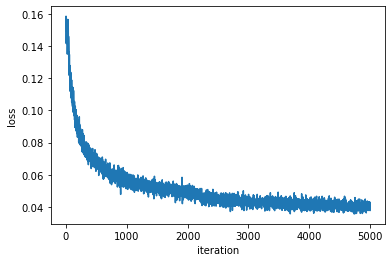

reconstruction loss is:


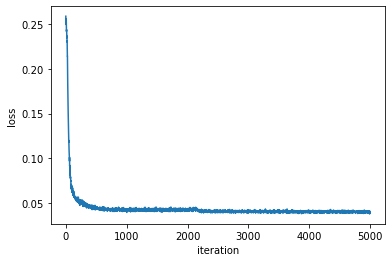

0.0763362198880977 0.5748115906038616


100%|██████████| 20/20 [00:46<00:00,  2.32s/it]

prediction loss is:


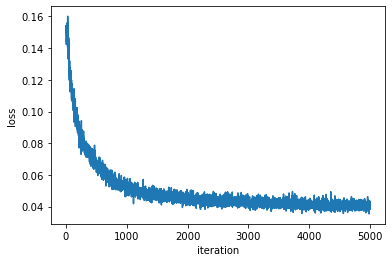

reconstruction loss is:


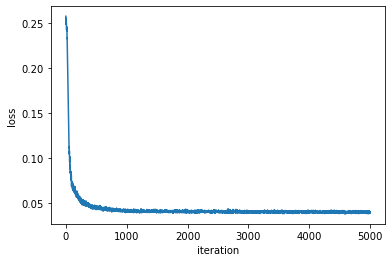

0.07027368039050036 0.6019395040845829


100%|██████████| 20/20 [00:45<00:00,  2.27s/it]

prediction loss is:


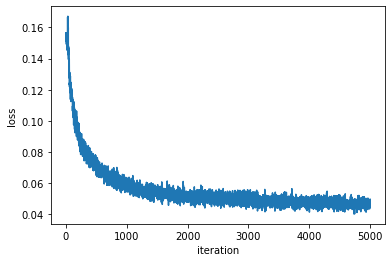

reconstruction loss is:


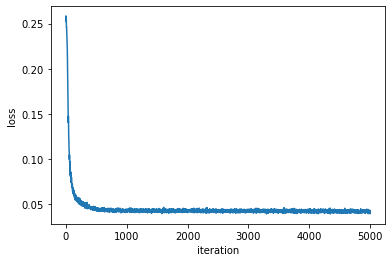

0.07065603396499322 0.641424026069259


100%|██████████| 20/20 [00:46<00:00,  2.34s/it]

prediction loss is:


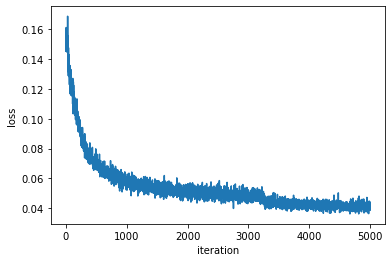

reconstruction loss is:


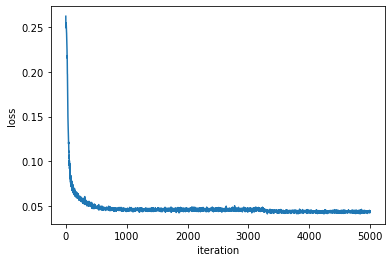

0.06483853444362887 0.702965840154342


100%|██████████| 20/20 [00:45<00:00,  2.26s/it]

prediction loss is:


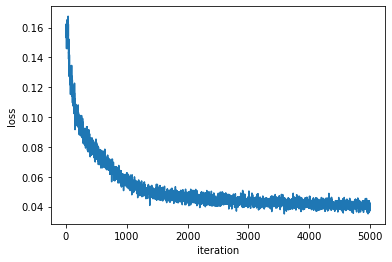

reconstruction loss is:


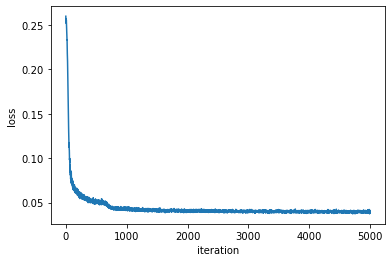

0.07981269401423632 0.5300302725261353


In [4]:
train_x, train_y, test_x, test_y = preprocess('pbmc_data.h5ad',testlabel='seq')
train_x = np.log2(train_x + 1)
test_x = np.log2(test_x + 1)
# train_x, test_x = transformation(train_x, test_x)
mms = MinMaxScaler()
test_x = mms.fit_transform(test_x.T)
test_x = test_x.T
train_x = mms.fit_transform(train_x.T)
train_x = train_x.T
print(torch.__version__)
print(device)
seq = np.zeros((50,2))
for i in range(5):
    a,b = test(train_x, train_y, test_x, test_y, seed=i)

In [5]:
# train_x, train_y, test_x, test_y = preprocess('pbmc_data.h5ad','TPMPBMC.txt','PBMC2.csv')
train_x, train_y, test_x, test_y = preprocess('pbmc_data.h5ad',testlabel='microarray')

In [6]:
# train_x, train_y, test_x, test_y = preprocess(trainingdatapath='mouse_brain.h5ad', 
#                                               testx='ROSMAP_mouse2human_GEP.csv', 
#                                               testy='ROSMAP_IHC_fractions.csv')

In [7]:
train_x = np.log2(train_x + 1)
test_x = np.log2(test_x + 1)
mms = MinMaxScaler()
test_x = mms.fit_transform(test_x.T)
test_x = test_x.T
train_x = mms.fit_transform(train_x.T)
train_x = train_x.T
print(np.sum(np.isnan(test_x)))
print('train_x shape',train_x.shape)
print('train_y shape',train_y.shape)
print('test_x shape',test_x.shape)
print('test_y shape',test_y.shape)

0
train_x shape (32012, 9036)
train_y shape (32012, 6)
test_x shape (20, 9036)
test_y shape (20, 6)


1.8.0
cuda


100%|██████████| 19/19 [00:41<00:00,  2.17s/it]

prediction loss is:


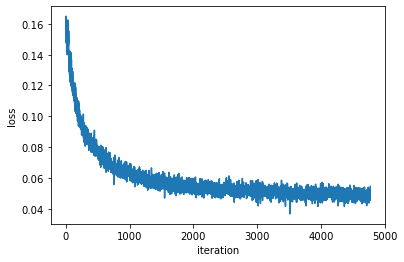

reconstruction loss is:


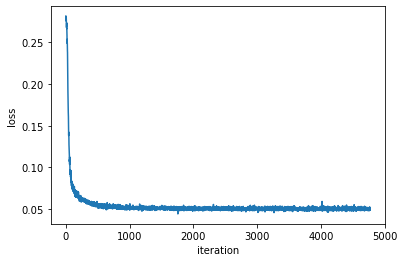

0.07709623035908365 0.6896888723254634


100%|██████████| 19/19 [00:40<00:00,  2.13s/it]

prediction loss is:


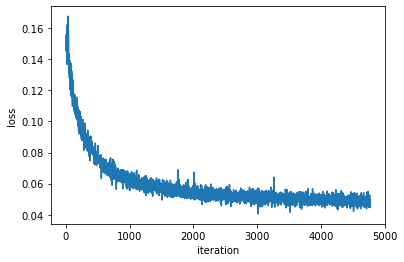

reconstruction loss is:


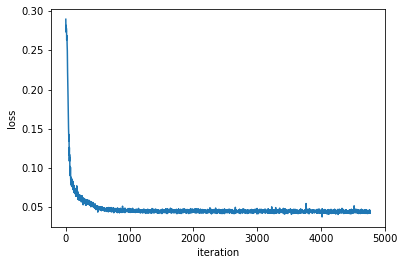

0.09091922149646715 0.6117959164237379


100%|██████████| 19/19 [00:41<00:00,  2.18s/it]

prediction loss is:


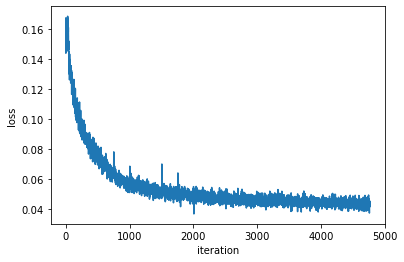

reconstruction loss is:


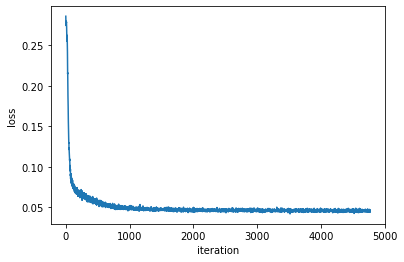

0.08450503311550865 0.6073477736638085


100%|██████████| 19/19 [00:40<00:00,  2.11s/it]

prediction loss is:


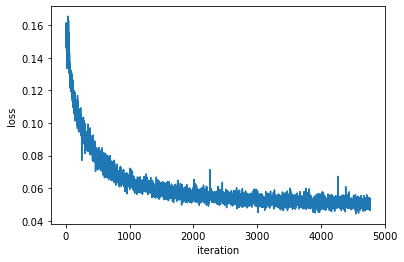

reconstruction loss is:


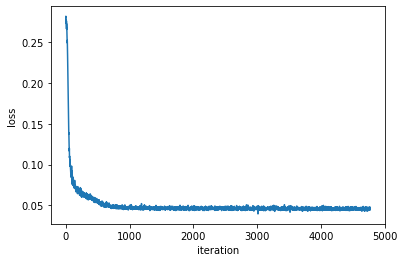

0.08259878380740683 0.6555599442604235


100%|██████████| 19/19 [00:40<00:00,  2.16s/it]

prediction loss is:


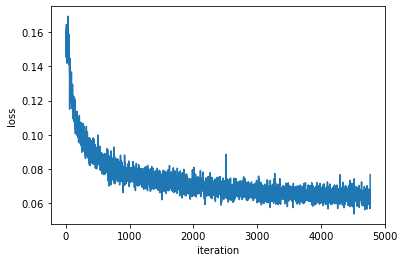

reconstruction loss is:


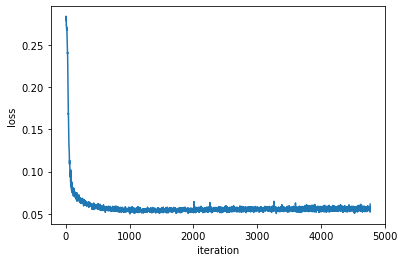

0.08896349628165365 0.5985326223210696


In [8]:
print(torch.__version__)
print(device)
microarray = np.zeros((50,2))
for i in range(5):
    a,b = test(train_x, train_y, test_x, test_y, seed=i)

1.8.0
cuda


100%|██████████| 20/20 [01:35<00:00,  4.77s/it]

prediction loss is:


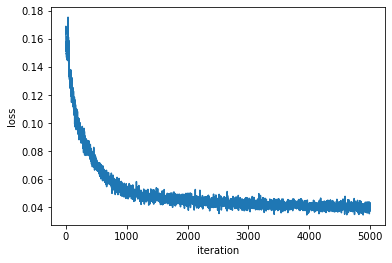

reconstruction loss is:


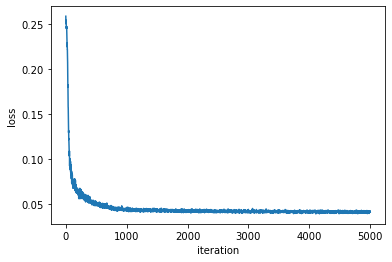

0.04089013749832908 0.7277849238245293


100%|██████████| 20/20 [01:35<00:00,  4.78s/it]

prediction loss is:


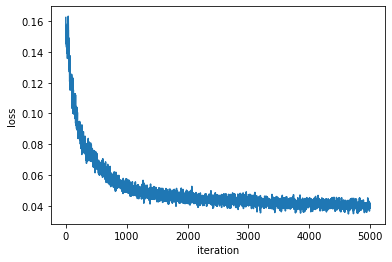

reconstruction loss is:


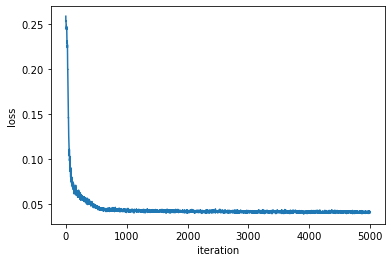

0.05196129509970545 0.6192204360732746


100%|██████████| 20/20 [01:36<00:00,  4.82s/it]

prediction loss is:


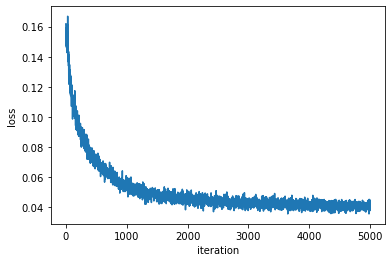

reconstruction loss is:


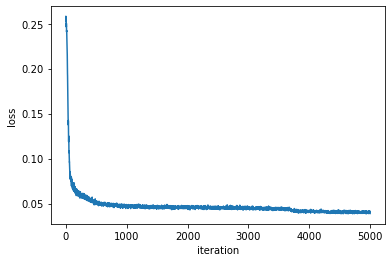

0.05311585758825143 0.639874910291942


100%|██████████| 20/20 [01:34<00:00,  4.72s/it]

prediction loss is:


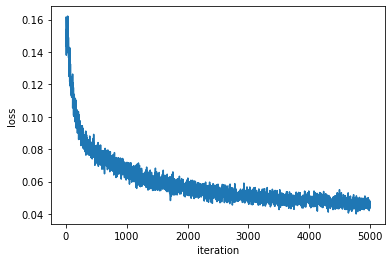

reconstruction loss is:


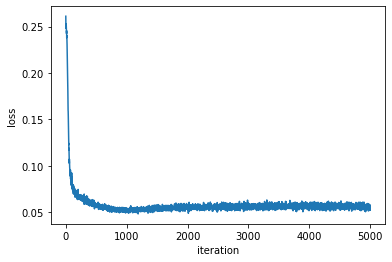

0.04711729647404618 0.6397490633700185


100%|██████████| 20/20 [01:34<00:00,  4.71s/it]

prediction loss is:


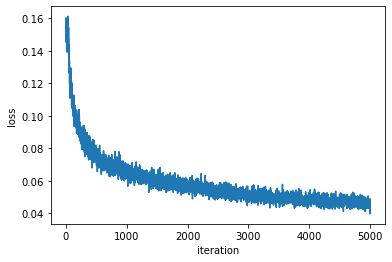

reconstruction loss is:


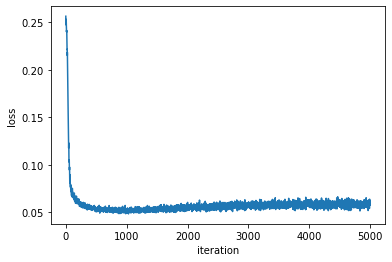

0.04471664998743268 0.6807180311951729


In [9]:
train_x, train_y, test_x, test_y = preprocess('pbmc_data.h5ad','TPMPBMC.txt','PBMC2.csv')
train_x = np.log2(train_x + 1)
test_x = np.log2(test_x + 1)
# train_x, test_x = transformation(train_x, test_x)
mms = MinMaxScaler()
test_x = mms.fit_transform(test_x.T)
test_x = test_x.T
train_x = mms.fit_transform(train_x.T)
train_x = train_x.T
print(torch.__version__)
print(device)
pbmc2 = np.zeros((50,2))
for i in range(5):
    a,b = test(train_x, train_y, test_x, test_y, seed=i)

In [10]:
def preprocess(trainingdatapath, testx, testy):
    # mouse brain dataset
    trainset = read_h5ad(trainingdatapath)
    testset = pd.read_csv(testx,index_col=0)
    #display(testset)
    testlabel = pd.read_csv(testy,index_col=0)
    #display(testlabel)
    test_y = testlabel.iloc[:,:].values
    test_y = np.array(test_y,dtype=float)
    ### refraction
    for i, values in enumerate(test_y):
        r_sum = np.sum(values)
        if r_sum == 0:
            pass
        else:
            test_y[i] = test_y[i] / r_sum
    ### find intersect genes
    intersection_genes = list(testset.index.intersection(trainset.var.index))
    print(len(intersection_genes))
    test_x = testset.loc[intersection_genes]
    test_x = test_x.T.values
    simuvar = list(trainset.var.index)
    intersection_gene_position = []
    for gene in intersection_genes:
        intersection_gene_position.append(simuvar.index(gene))
    selected = np.zeros((len(intersection_genes), len(trainset.X)))
    for i in range(selected.shape[0]):
        selected[i] = trainset.X.T[intersection_gene_position[i]]
    train_x = selected.T
    
    
    # merge ex&in-neurons
    #trainset.obs['Neurons'] = trainset.obs['ExNeurons']+trainset.obs['InNeurons']
    # find intersect cell proportions
    intersection_cell = list(testlabel.columns.intersection(trainset.obs.columns))
    train_y = trainset.obs[intersection_cell].values
    ### refraction
    for i, values in enumerate(train_y):
        r_sum = np.sum(values)
        if r_sum == 0:
            pass
        else:
            train_y[i] = train_y[i] / r_sum
    ### variance cutoff
    label = test_x.var(axis=0) > 0.1
    test_x_new = np.zeros((test_x.shape[0],np.sum(label)))
    train_x_new = np.zeros((train_x.shape[0],np.sum(label)))
    k = 0
    for i in range(len(label)):
        if label[i] == True:
            test_x_new[:,k] = test_x[:,i]
            train_x_new[:,k] = train_x[:,i]
            k += 1
    
    return train_x_new, train_y, test_x_new, test_y

10836
train_x shape (30000, 10184)
train_y shape (30000, 5)
test_x shape (41, 10184)
test_y shape (41, 5)
1.8.0
cuda


100%|██████████| 21/21 [00:43<00:00,  2.06s/it]

prediction loss is:


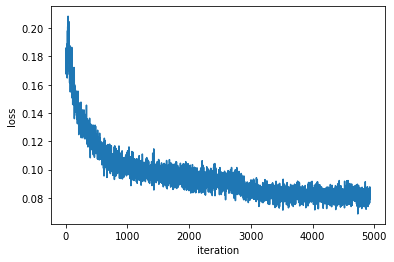

reconstruction loss is:


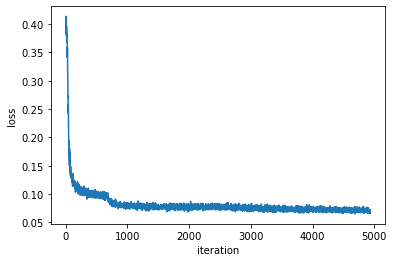

0.0738779622949004 0.7610262898354571


100%|██████████| 21/21 [00:43<00:00,  2.07s/it]

prediction loss is:


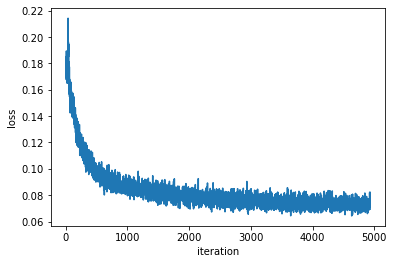

reconstruction loss is:


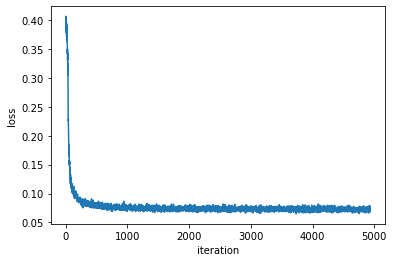

0.05924926085906318 0.8741880701227821


100%|██████████| 21/21 [00:43<00:00,  2.05s/it]

prediction loss is:


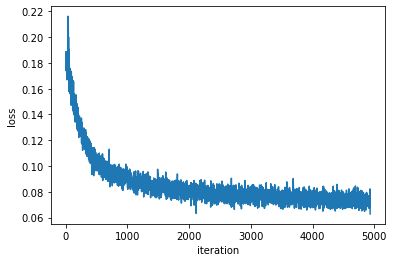

reconstruction loss is:


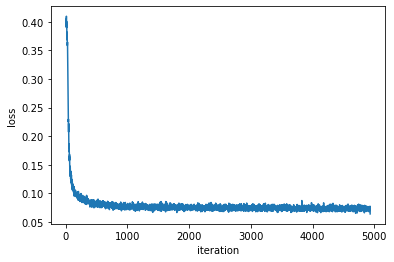

0.04129365699424457 0.9141011469568548


100%|██████████| 21/21 [00:43<00:00,  2.06s/it]

prediction loss is:


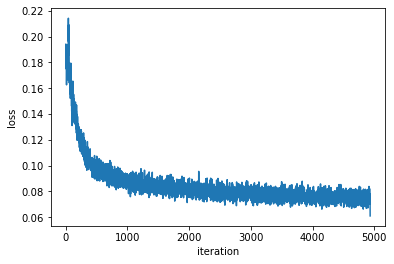

reconstruction loss is:


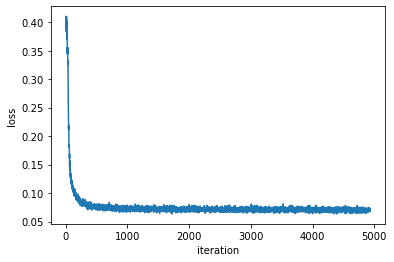

0.05319121892221616 0.8909859129733093


100%|██████████| 21/21 [00:43<00:00,  2.07s/it]

prediction loss is:


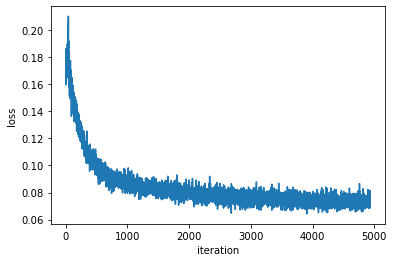

reconstruction loss is:


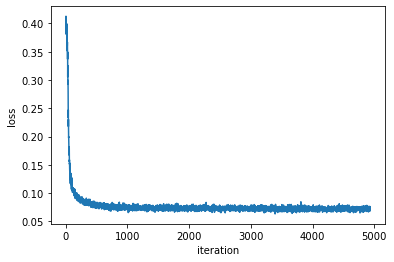

0.06844607064154655 0.7918878609779627


In [11]:
train_x, train_y, test_x, test_y = preprocess(trainingdatapath='mouse_brain.h5ad', 
                                              testx='ROSMAP_mouse2human_GEP.csv', 
                                              testy='ROSMAP_IHC_fractions.csv')
train_x = np.log2(train_x + 1)
test_x = np.log2(test_x + 1)
# train_x, test_x = transformation(train_x, test_x)
mms = MinMaxScaler()
test_x = mms.fit_transform(test_x.T)
test_x = test_x.T
train_x = mms.fit_transform(train_x.T)
train_x = train_x.T
print('train_x shape',train_x.shape)
print('train_y shape',train_y.shape)
print('test_x shape',test_x.shape)
print('test_y shape',test_y.shape)
print(torch.__version__)
print(device)
mouse = np.zeros((50,2))
for i in range(5):
    a,b = test(train_x, train_y, test_x, test_y, seed=i)